# In this notebook we'll provide an example spectral decomposition

TODO add emcee example, including post-processing template

In [31]:
import math
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
import os
import glob
from lmfit import Parameters, fit_report, minimize
import time
import corner

from SpecDecomp import SpecDecomp

OII1_WL=3729.225
OII2_WL=3735.784
NeIII1_WL=3868.265
NeIII2_WL=3966.244
SII_WL=4073.125
Hdelta_WL=4102
Hgamma_WL=4341

HeII_WL=4685

Hbeta_WL=4862.721
OIII1_WL=4960.295
OIII2_WL=5008.239

def find_common_idx_range(wave,minWL,maxWL):
    '''
    Provides the minimum and maximum indices that live within the defined range.
    Note since array[start:stop] will not include index stop, idx_max will be the first index outside of the defined range.
    '''
    idx_min=0
    for i in range(len(wave)):
        if wave[i]>minWL:
            idx_min=i
            break

    # if max(wave)=maxWL, then if statement below will never trigger
    # in that case, idx_max=len(wave)
    idx_max=len(wave)
    for i in range(len(wave)):
        if wave[i]>maxWL:
            idx_max=i
            break

    return idx_min,idx_max

In [2]:
####################################################################################################################
############# USER SPECIFIED VALUES
####################################################################################################################

feii_template_path='./files/fe_op_templates.npy'
stellar_template_path='./files/PyQSOfit_MILES_templates.dat'
balmer_cont_template_path='./files/balmer_cont_templates.npy'
balmer_highorder_template_path='./files/balmer_highorder_templates.npy'

num_templates_feii=100
num_templates_host=8
num_templates_balmer_cont=20
num_templates_balmer_highorder=21

min_WL=3750       # minimum wavelength for fitting
max_WL=5550       # maximum wavelength for fitting


pl_feii_wls=[[4150,4250],[4450,4800],[5050,5750]] # list of lists, gives WL regions for initial fit w only power law and Fe II
host_narrow_wls=[[3750,4080]] # list of lists, gives WL regions for host + narrow line fits near 4000 A
hdelta_hgamma_wls=[[4000,4500]] # list of lists, gives WL regions for H Delta and H Gamma fits
hbeta_oiii_wls=[[4600,5100]]  # list of lists, gives WL regions for He II, H Beta and O III fits


pl_norm_wl=4000   # Wavelength at which the power law is normalized
        
broad_start=15    # starting width for broad lines
narrow_start=5    # starting width for narrow lines

broad_max=200     # max width for broad lines
narrow_max=50     # max width for narrow lines

max_offset=70     # max offset for center of emission line
max_amp=1000       # max amplitude of gaussian emission lines

minimize_method=['powell'] # see https://lmfit.github.io/lmfit-py/fitting.html for list of fitting methods

nan_policy='raise'
verbose=False

####################### Below are all model parameters listed in order #####################################
############################################################################################################
# params['pl_norm']
# params['pl_alpha']
# params['fe_ii_width']
# params['fe_ii_scale']
# params['host_age']
# params['host_scale']
# params['bal_cont_tau']
# params['bal_cont_scale']
# params['bal_high_width']
# params['bal_high_scale']
# params['ampOII3729']
# params['ampOII3735']
# params['ampNeIII3868']
# params['ampNeIII3966']
# params['ampSII4073']
# params['groupampratio']
# params['groupWLoffset1']
# params['groupWLoffset2']
# params['groupwidth1']
# params['groupwidth2']
# params['ampHDelta']
# params['WLHDelta']
# params['widthHDelta']
# params['ampHGamma']
# params['WLHGamma']
# params['widthHGamma']

# params['ampHeII']
# params['WLHeII']
# params['widthHeII']

# params['ampHBeta1']
# params['WLHBeta1']
# params['widthHBeta1']
# params['ampHBeta2']
# params['WLHBeta2']
# params['widthHBeta2']
# params['ampHBeta3']
# params['WLHBeta3']
# params['widthHBeta3']
# params['ampHBeta4']
# params['WLHBeta4']
# params['widthHBeta4']
# params['ampNHBeta']
# params['ampOIII50071']
# params['WLOIII50071']
# params['widthOIII50071']
# params['ampOIII50072']
# params['WLOIII50072']
# params['widthOIII50072']


####################### Specify Upper and Lower bounds for each model parameter below ############################
##################################################################################################################

lower_bounds=[0,-10,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,-5,-5,0,0,
              0,Hdelta_WL-max_offset,0,0,Hgamma_WL-max_offset,0,
              0,HeII_WL-max_offset,0,
              0,Hbeta_WL-max_offset,0,0,Hbeta_WL-max_offset,0,
              0,Hbeta_WL-max_offset,0,0,Hbeta_WL-max_offset,0,
              0,
              0,OIII2_WL-max_offset,0,0,OIII2_WL-max_offset,0]

upper_bounds=[500,4,
              num_templates_feii-1.1,200,
              num_templates_host-1.1,200,
              num_templates_balmer_cont-1.1,200,
              num_templates_balmer_highorder-1.1,200,
              max_amp,max_amp,max_amp,max_amp,max_amp,100,5,5,narrow_max,narrow_max,
              max_amp,Hdelta_WL+max_offset,broad_max,max_amp,Hgamma_WL+max_offset,broad_max,
              max_amp,HeII_WL+max_offset,broad_max,
              max_amp,Hbeta_WL+max_offset,broad_max,max_amp,Hbeta_WL+max_offset,broad_max,
              max_amp,Hbeta_WL+max_offset,broad_max,max_amp,Hbeta_WL+max_offset,broad_max,
              max_amp,
              max_amp,OIII2_WL+max_offset,narrow_max,max_amp,OIII2_WL+max_offset,narrow_max]

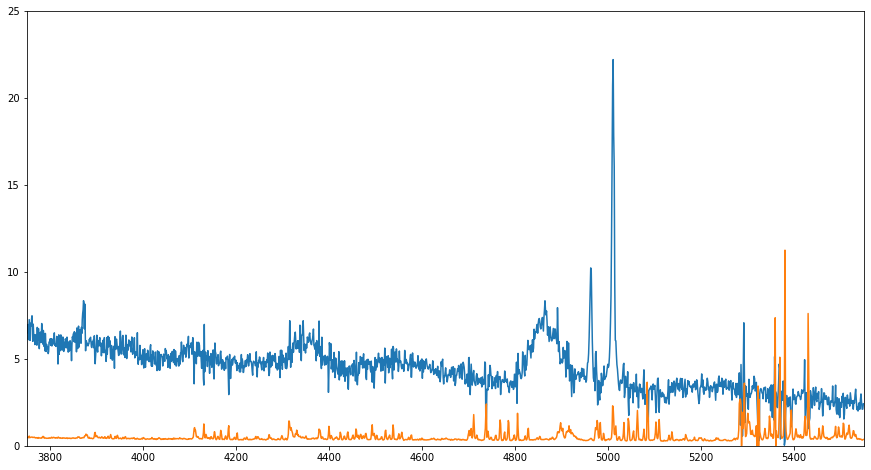

In [3]:
# load in example spectrum

data=np.load('./files/spec-9141-57663-0789_unred_z.npy',allow_pickle=True)
WL=data.item().get('WL')
INT=data.item().get('INT')
ERR=data.item().get('ERR')

# clip spectrum onto desired WL range
idx_min,idx_max=find_common_idx_range(WL,min_WL,max_WL)
wave=WL[idx_min:idx_max]
flux=INT[idx_min:idx_max]
err=ERR[idx_min:idx_max]

plt.axis([3750,5550,0,25])
plt.plot(wave,flux)
plt.plot(wave,err)

In [12]:
# Initialize Spectral Decomposition Class

spec=SpecDecomp(wave,
                flux,
                err,
                feii_template_path,
                stellar_template_path,
                balmer_cont_template_path,
                balmer_highorder_template_path)

# Guess initial model parameters
params_init=spec.guess_initial_params()

# Fit Spectrum
params_final=spec.fit(params_init,lower_bounds,upper_bounds,minimize_method[0],verbose=verbose)

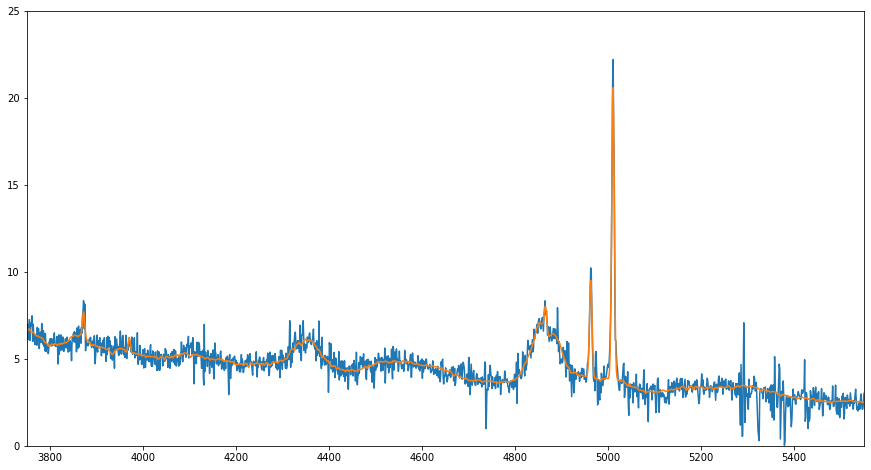

In [13]:
# Plot model and spectrum
model=spec.construct_model(spec.wave,spec.params_final,fit_type='full')

plt.axis([3750,5550,0,25])
plt.plot(WL,INT)
plt.plot(spec.wave,model)

# Now we'll fit the same data with emcee

I'm following the emcee tutorial stuff here https://emcee.readthedocs.io/en/stable/tutorials/line/

In [20]:
nwalkers=200
nsteps=1000


# Initialize Spectral Decomposition Class
spec=SpecDecomp(wave,
                flux,
                err,
                feii_template_path,
                stellar_template_path,
                balmer_cont_template_path,
                balmer_highorder_template_path)

# Guess initial model parameters
params_init=spec.guess_initial_params()

# Fit Spectrum with MCMC
sampler=spec.fit_emcee(params_init,lower_bounds,upper_bounds,nwalkers,nsteps)

100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]


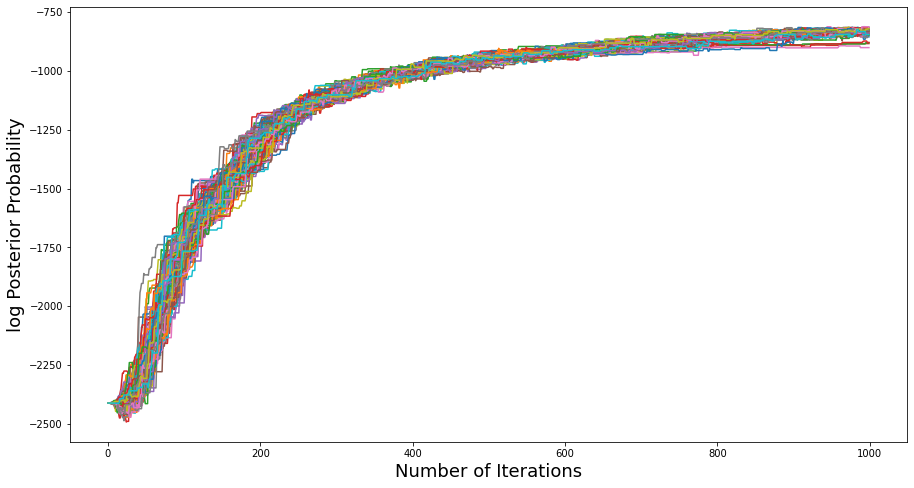

In [42]:
log_prob=sampler.get_log_prob()

plt.xlabel('Number of Iterations',fontsize=18)
plt.ylabel('log Posterior Probability',fontsize=18)
plt.plot(log_prob[:,:])
plt.show()

Text(0.5, 0, 'Walker')

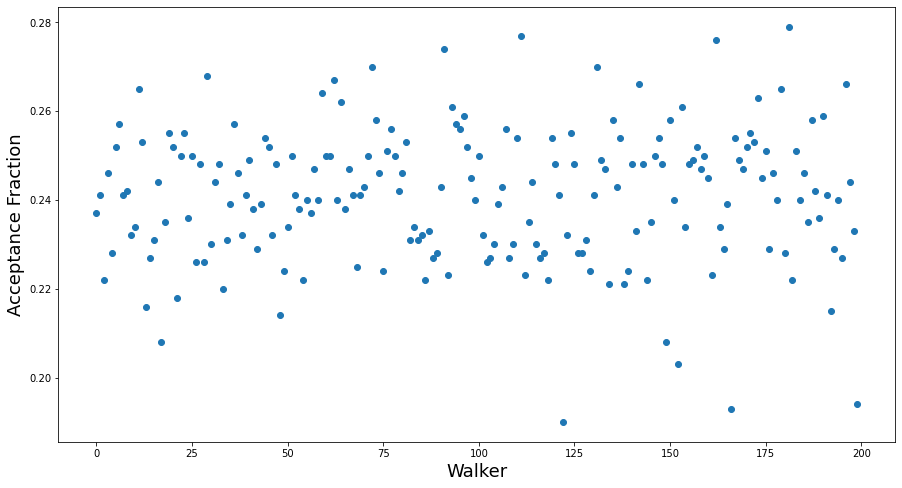

In [48]:
plt.scatter(np.arange(nwalkers),sampler.acceptance_fraction)
plt.ylabel('Acceptance Fraction',fontsize=18)
plt.xlabel('Walker',fontsize=18)

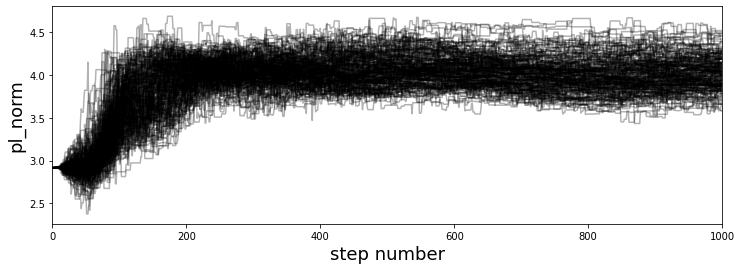

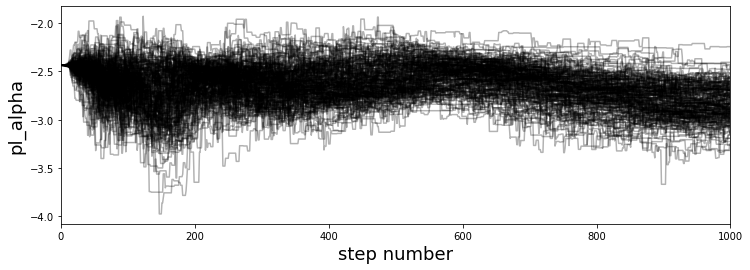

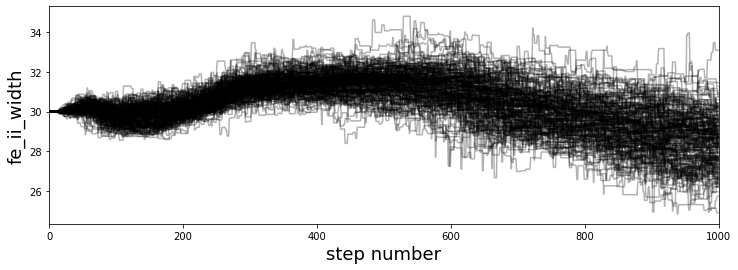

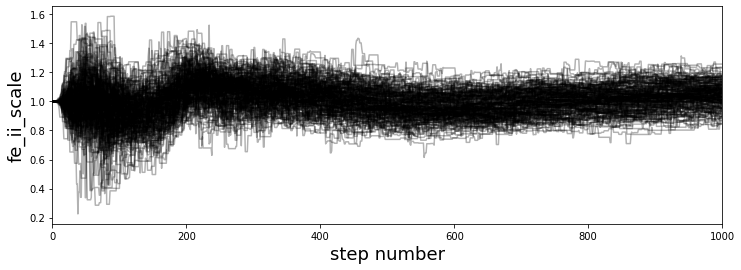

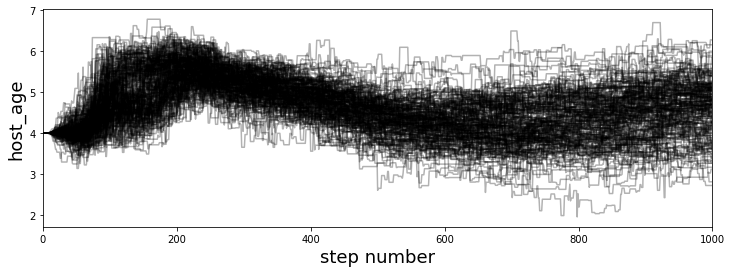

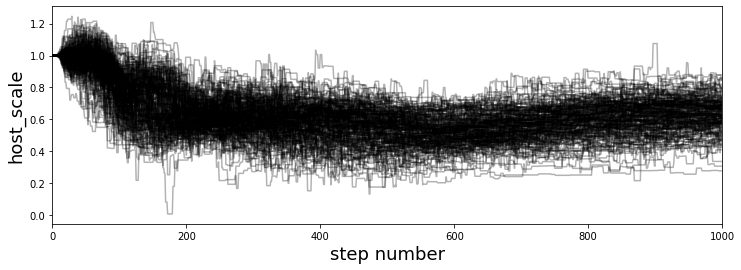

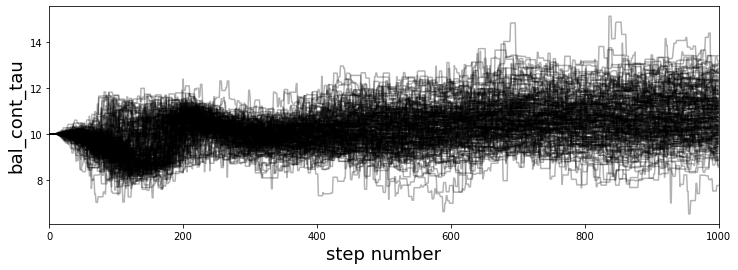

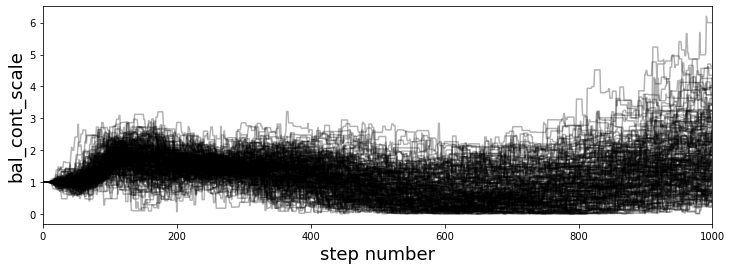

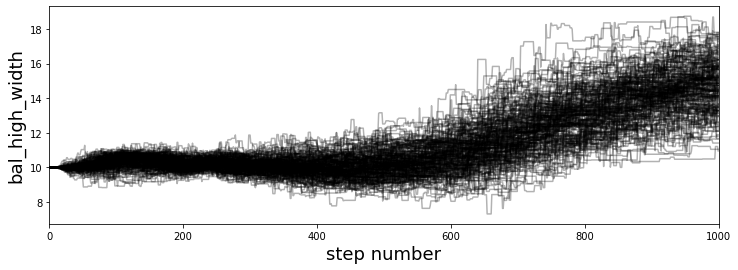

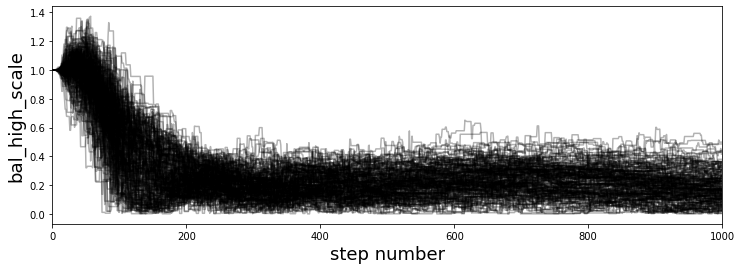

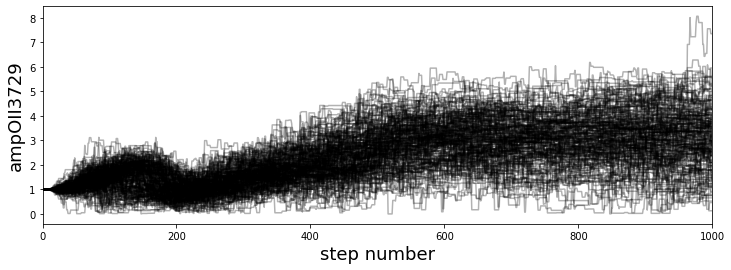

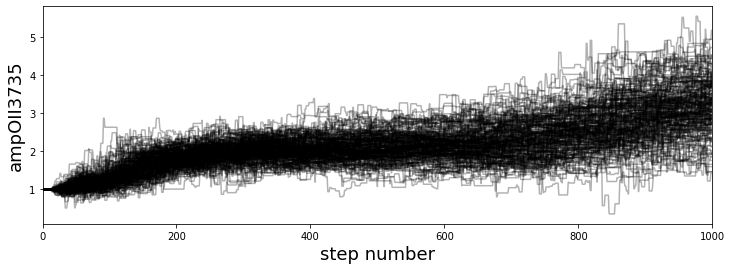

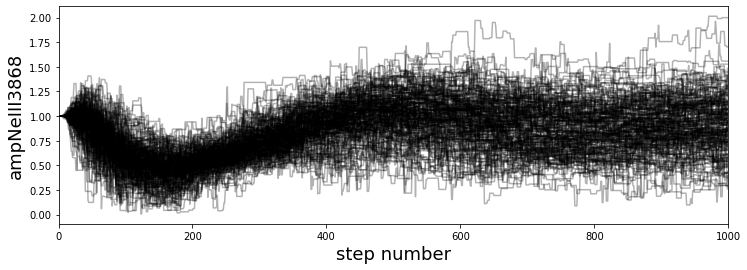

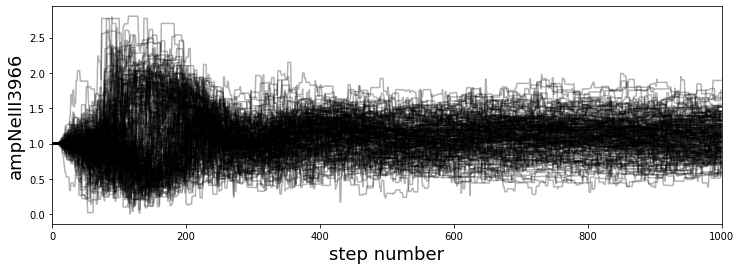

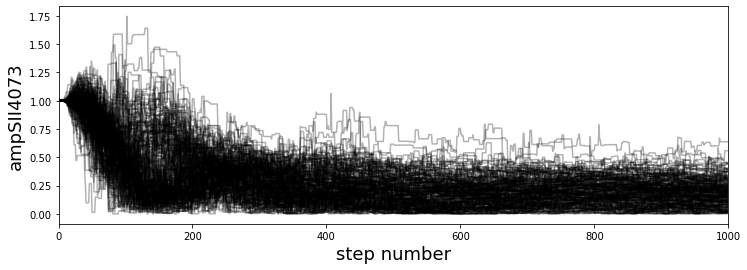

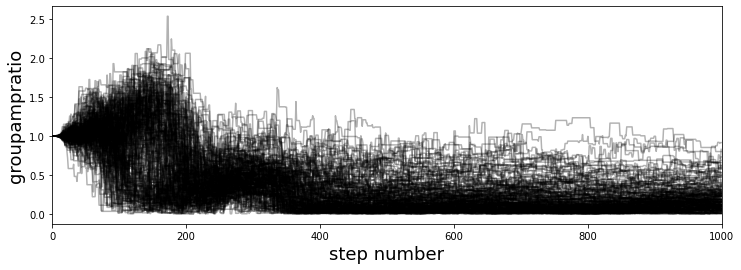

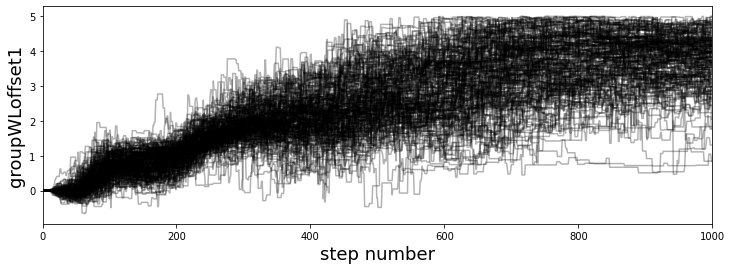

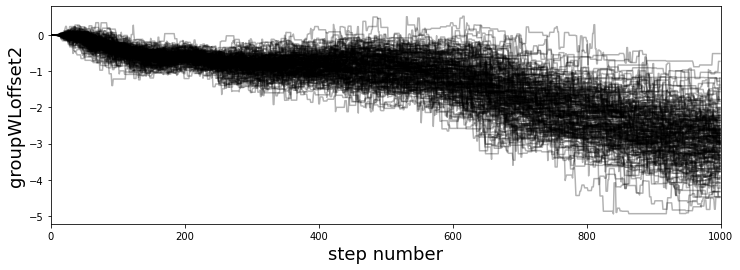

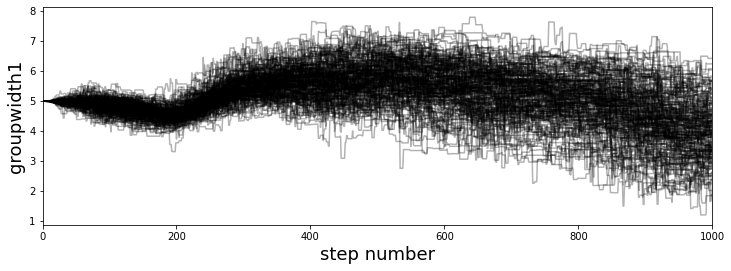

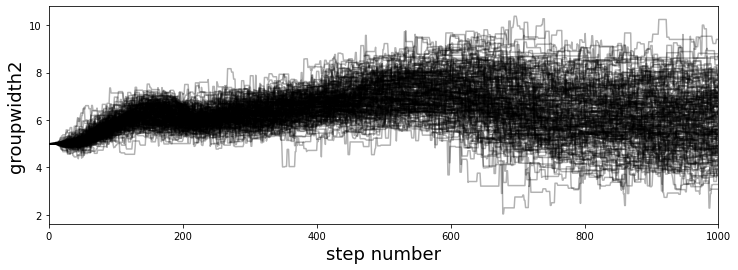

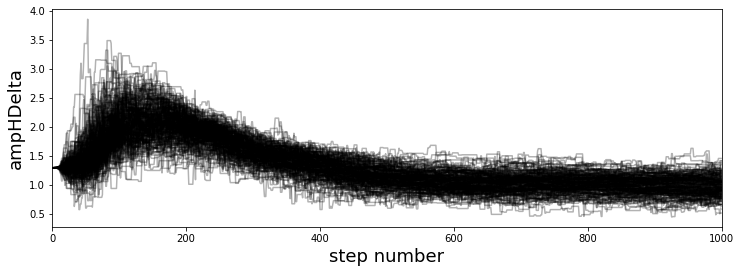

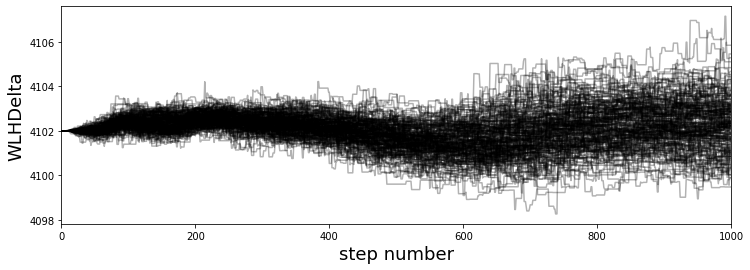

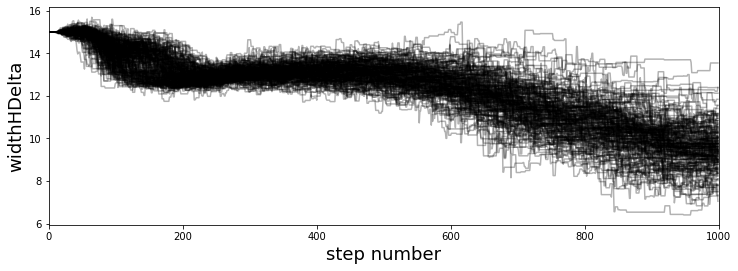

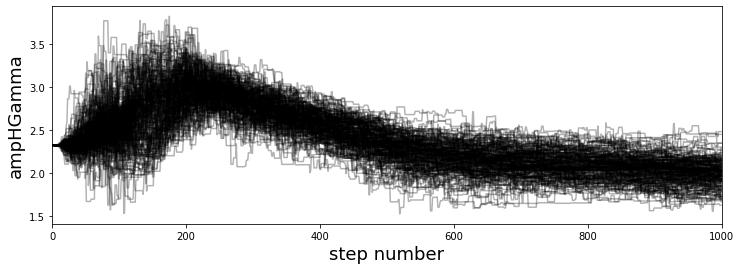

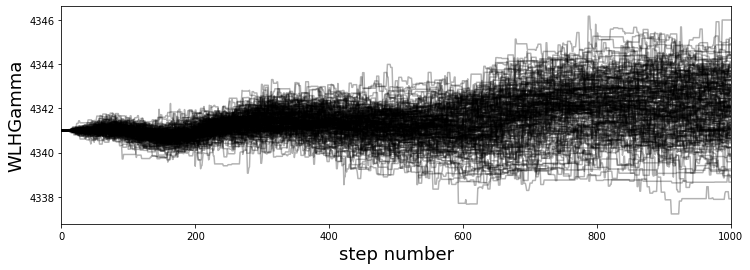

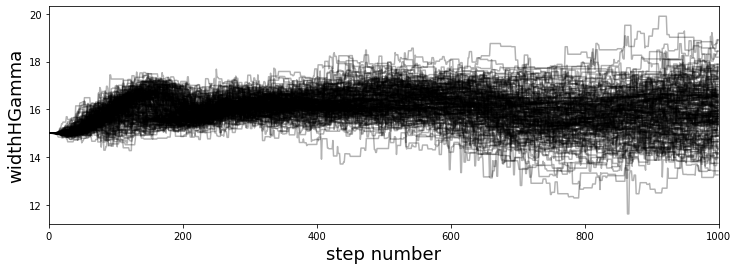

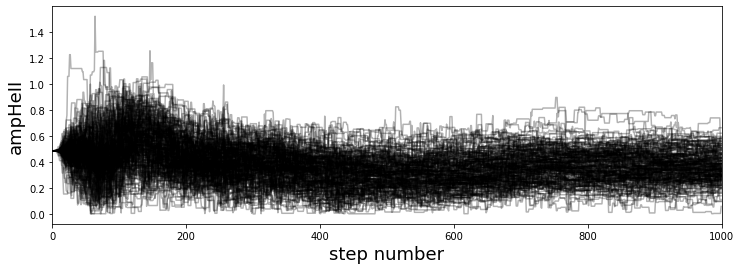

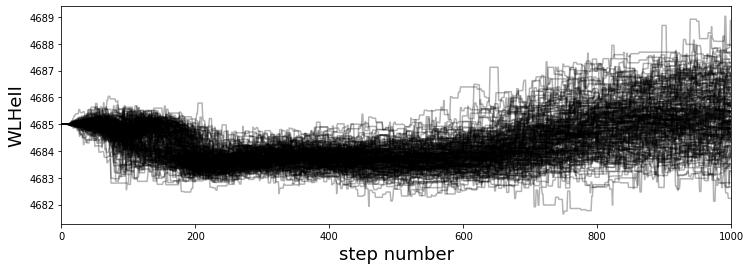

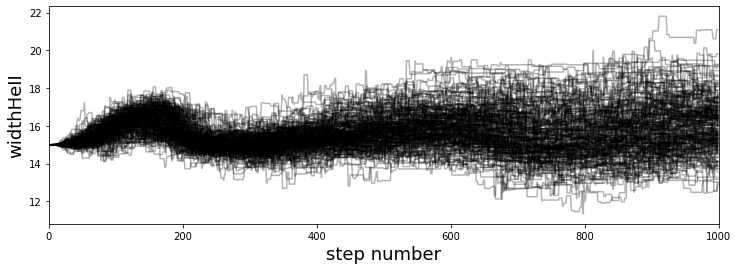

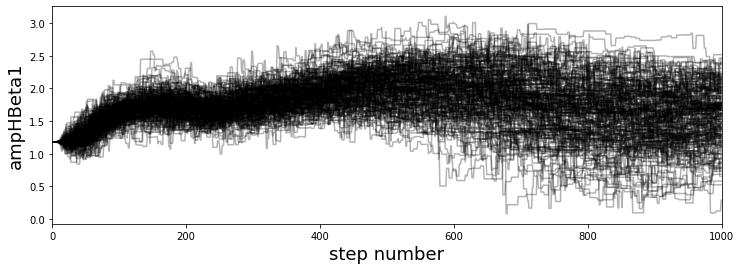

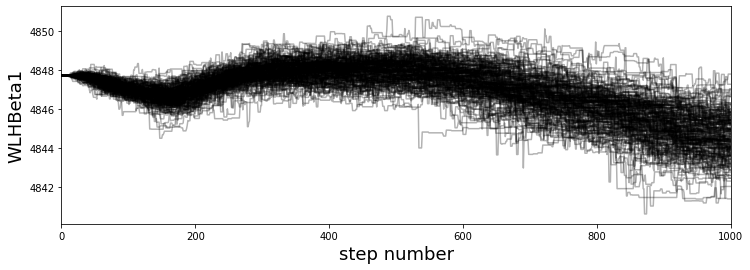

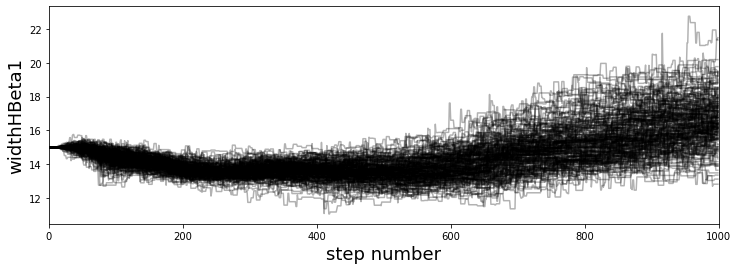

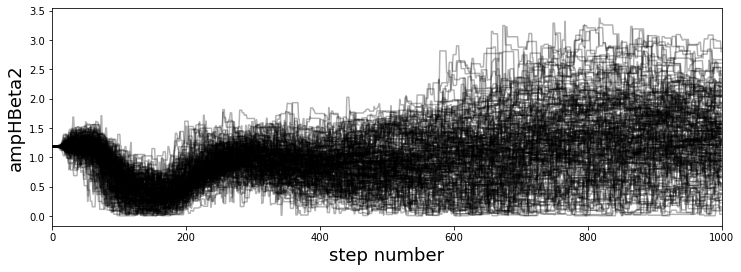

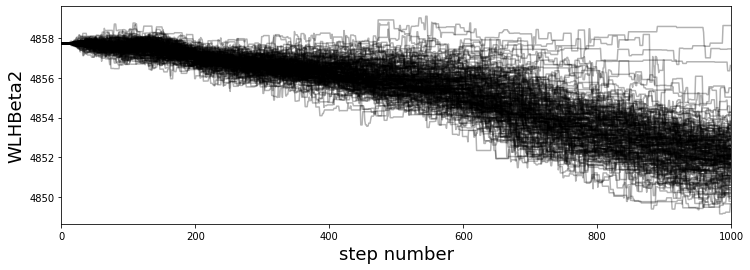

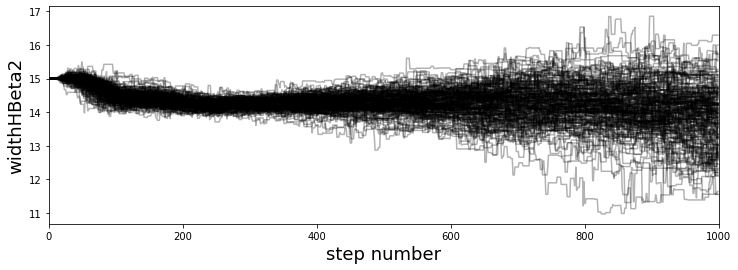

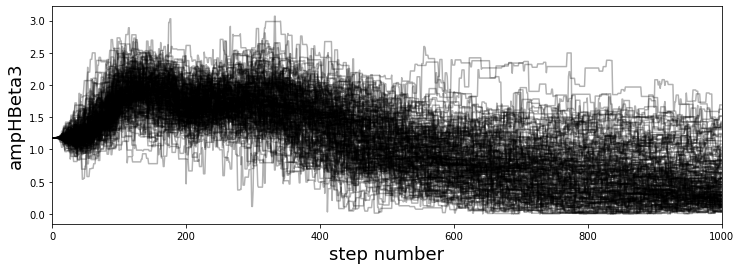

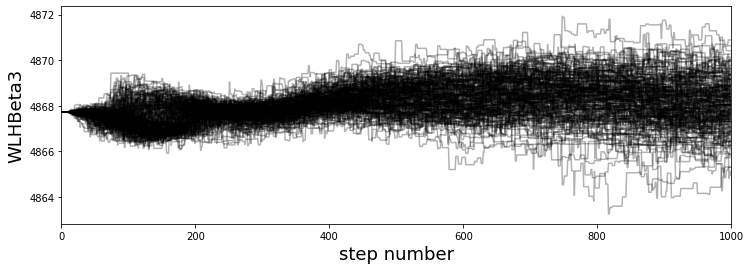

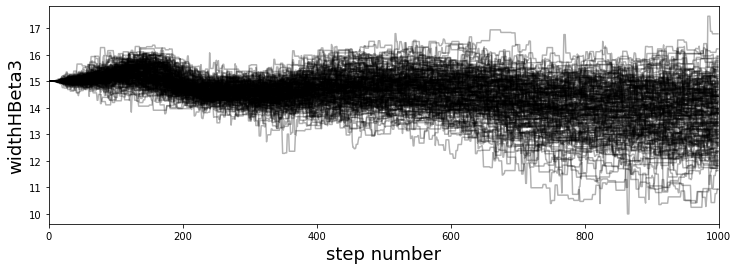

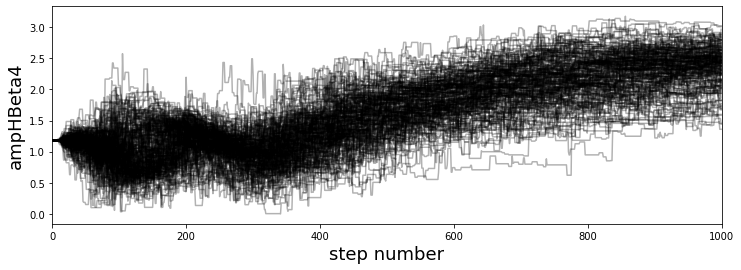

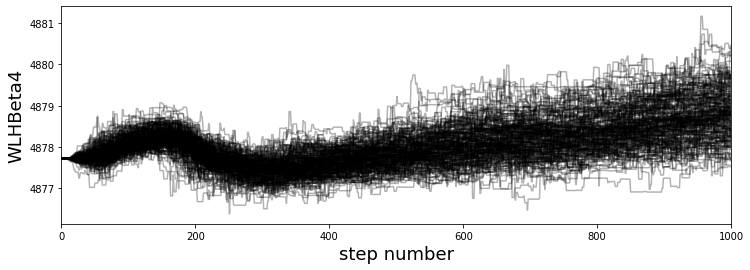

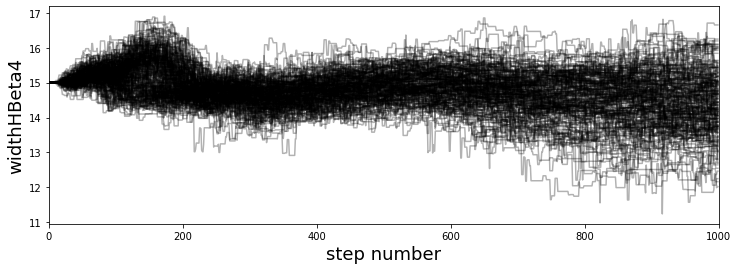

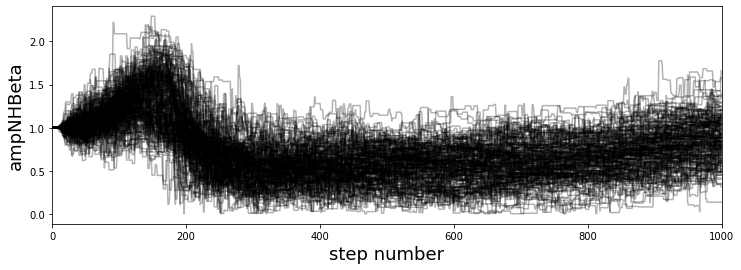

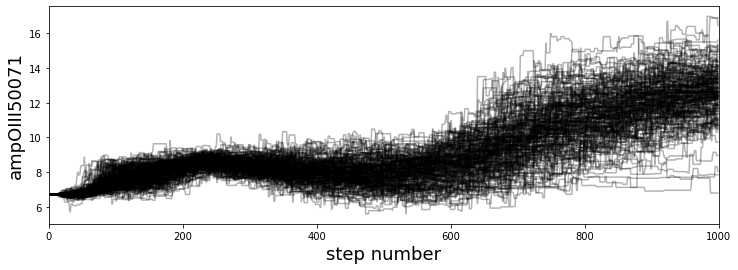

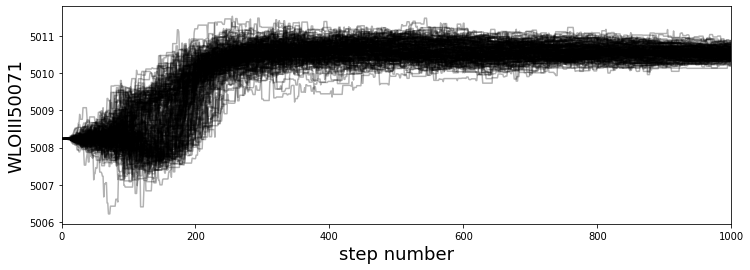

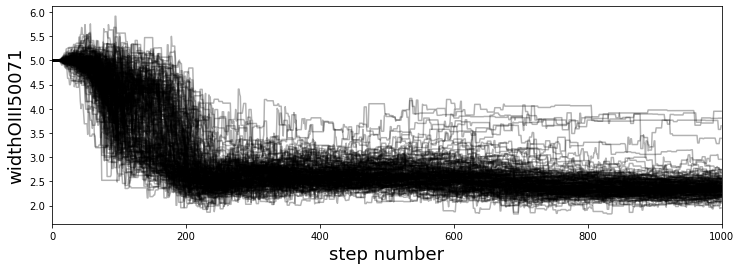

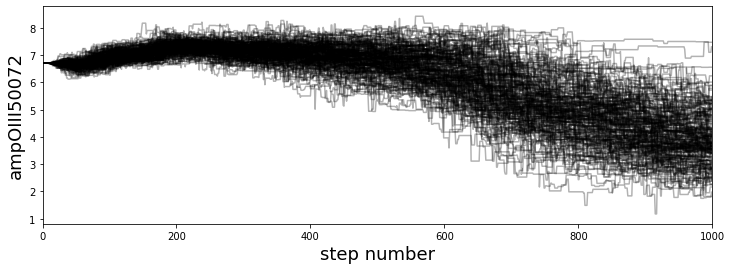

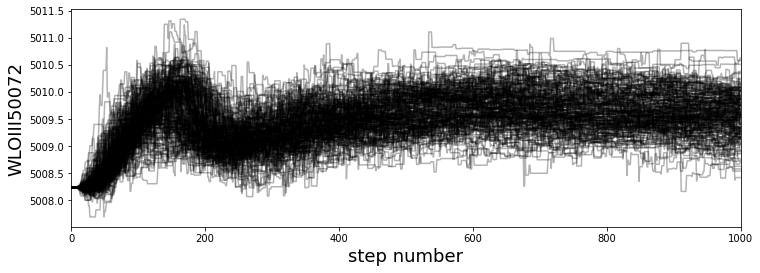

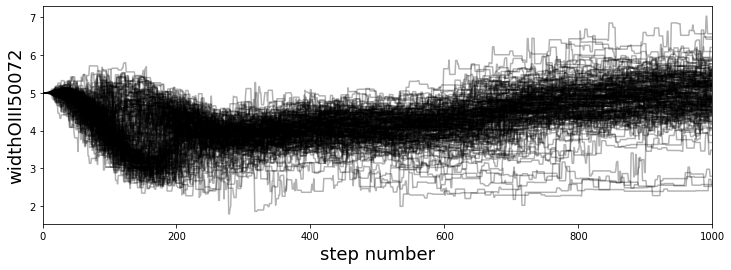

In [30]:
rcParams['figure.figsize'] = 12,4

samples = sampler.get_chain()
labels=[key for key,val in params_init.items()]
ndim=len(labels)
for i in range(ndim):

    plt.plot(samples[:, :, i], "k", alpha=0.3)
    plt.xlim(0, len(samples))
    plt.ylabel(labels[i],fontsize=18)
    plt.xlabel("step number",fontsize=18)
    plt.show()


In [24]:
# Now we decide a burnin and a thin value, then flatten the samples

#tau = sampler.get_autocorr_time()
#print('mean autocorrelation time '+str(np.average(tau)))


burnin=10
thin=15

flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

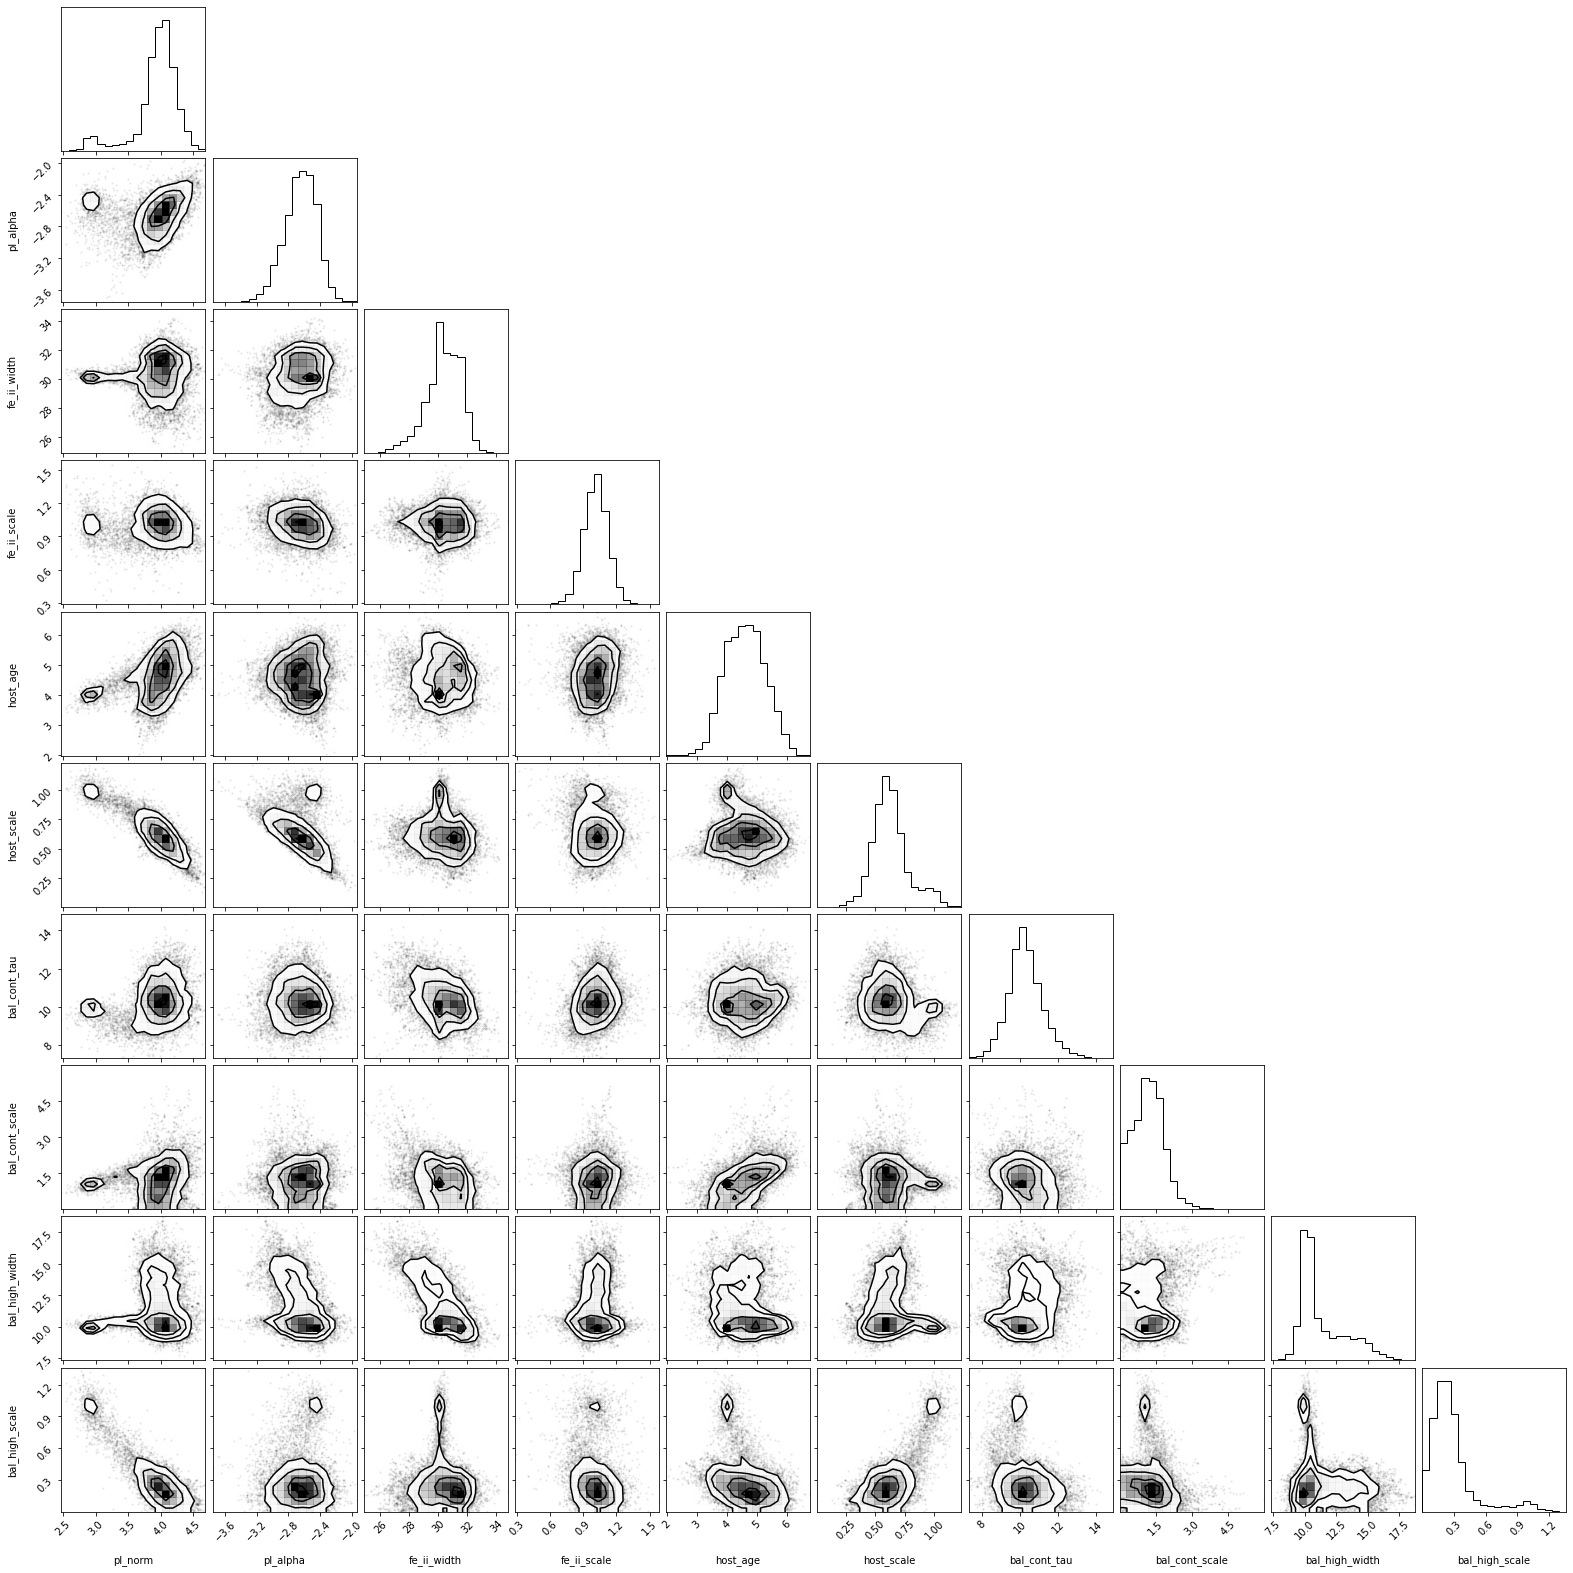

In [38]:
# we can make corner plots


fig = corner.corner(flat_samples[:,:10], labels=labels[:10])

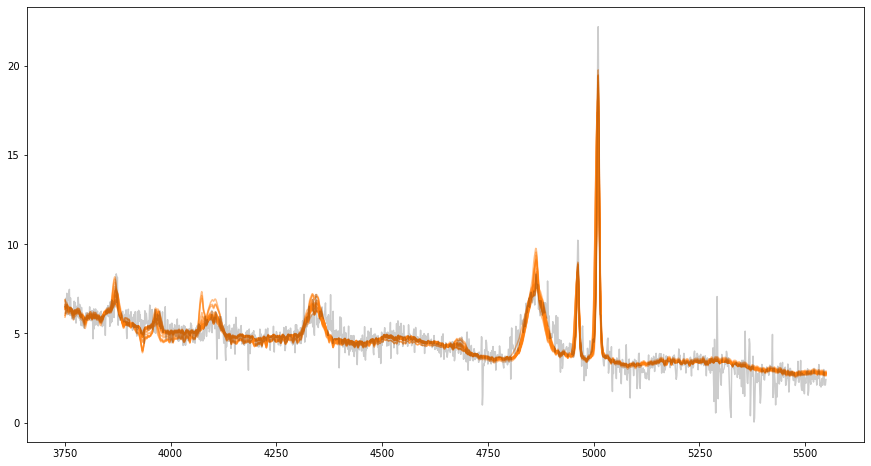

In [28]:
# Now we take some random samples of the converged chain and plot the model 

num_samples=20

inds = np.random.randint(len(flat_samples), size=num_samples)
for ind in inds:
    params = flat_samples[ind]
    plt.plot(spec.wave, spec.construct_model_emcee(params), "C1", alpha=0.5)
plt.plot(spec.wave, spec.flux, c='k',alpha=0.2)
